In [3]:
from wandb.keras import WandbCallback
import wandb
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow import convert_to_tensor
import numpy as np
from transformers import TFDistilBertModel
from extract_bert_features import embed, make_pipe
from model_k import compile_ae_model, create_models_from_params
from scipy.spatial.distance import cosine
from tensorflow.keras.callbacks import EarlyStopping
from progress.bar import Bar
import pandas as pd

from timer import timer

import matplotlib.pyplot as plt

from spacyNER import get_spacy_NER_data


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:

emb_pipe = make_pipe('distilbert-base-uncased', TFDistilBertModel)

early_stopping_cb = EarlyStopping(
    monitor='loss', patience=3, verbose=1, min_delta=0.001)

Finished 'make_pipe' in 99.204 secs


In [ ]:
ae_model = compile_ae_model()

# # some fake data
# fake_train_x = np.random.rand(1000, 768)
# fake_test_x = np.random.rand(500, 768)
# fake_train_y = np.random.rand(1000, 1)
# fake_test_y = np.random.rand(500, 1)
# ae_model.fit(
#     x=fake_train_x,
#     y=fake_train_y,
#     epochs=5,
#     batch_size=100,
#     shuffle=True,
#     validation_data=(fake_test_x, fake_test_y))


In [ ]:


def test():
    z = ['The brown fox jumped over the dog',
         'The ship sank in the Atlantic Ocean',
         'Urban foxes sometimes fight with dogs']
    print("Start")
    embedding_features1 = embed(emb_pipe, z[0])
    print(
        f"emb shape is {embedding_features1.shape} for {len(z[0].split(' '))} words")
    embedding_features2 = embed(emb_pipe, z[1])
    embedding_features3 = embed(emb_pipe, z[2])
    distance12 = 1-cosine(embedding_features1[0], embedding_features2[0])
    distance23 = 1-cosine(embedding_features2[0], embedding_features3[0])
    distance13 = 1-cosine(embedding_features1[0], embedding_features3[0])
    print(f"distance 1-2 {distance12}")
    print(f"distance 2-3 {distance23}")
    print(f"distance 1-3 {distance13}")

In [2]:
# create 1 training item per entity, given a token radius


@timer
def create_training_data_per_entity(
        length: int = 10,
        radius: int = 7) -> list:
    """
    Creates training data for the autoencoder.
    """
    print(f"Create Training Data for {length} items, radius {radius}")
    # get spacy data
    spacy_data = get_spacy_NER_data(length)
    print(f"Created NER Data for {len(spacy_data)} items")

    # get embedding data
    res = []
    bar = Bar('Processing', max=len(spacy_data))
    for s in spacy_data:
        for chunk in s["chunks"]:
            start_token = max(chunk["entity"].start-radius, 0)
            end_token = min(chunk["entity"].end+radius, len(s["nlp"]))
            short_sentence = s["nlp"][start_token:end_token]
            res.append({
                "sentence": short_sentence,
                "chunk": str(chunk["chunk"]),
                "label": chunk["entity"].label_,
                "embedding": embed(emb_pipe, str(short_sentence))
            })
            bar.next()
    bar.finish()
    # average all the embeddings in a sample, dropping 1st (CLS)
    for r in res:
        r["embedding"] = np.mean(r["embedding"][1:], axis=0)
    return res



In [3]:
# 
# CREATE TRAINING DATA
merged = create_training_data_per_entity(-1, 5)
print(len(merged))


Create Training Data for -1 items, radius 5


: 

: 

In [ ]:
# create full DF

x_train_np = np.stack([m["embedding"] for m in merged])

merged_df = pd.DataFrame(merged)
emb_df = pd.DataFrame(x_train_np)

merged_df.drop(columns=['embedding'], inplace=True)
df = pd.concat([merged_df, emb_df], axis=1)

print(df.shape)
# save data to csv
df.to_csv("./data/training_df.csv", index=False)
df.head()

# IMPORT import df from file


In [4]:
df = pd.read_csv("./data/training_df.csv")


# train df has only the embeddings
df.head()

def test_train_split(frac=0.8):
    training_data = df.sample(frac=frac, random_state=42)
    testing_data = df.drop(training_data.index)
    train_x_df = training_data.drop(columns=['chunk', 'label', 'sentence'])
    test_x_df = testing_data.drop(columns=['chunk', 'label', 'sentence'])
    print(f"Full df: {df.shape}")
    print(f"Train df: {train_x_df.shape}")
    print(f"Test df: {test_x_df.shape}")
    return train_x_df, test_x_df
train_x, test_x = test_train_split(0.8)

Full df: (3895, 771)
Train df: (3116, 768)
Test df: (779, 768)


In [ ]:
model = compile_ae_model()
model.fit(x_train, x_train, epochs=100, batch_size=100, shuffle=True)


In [5]:
# plot loss
# summarize history for loss
def plot_loss(history) -> None:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('validation')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


grid search

In [8]:
default = {
    "layers": [
        {"n": 768, "act": "relu"},
        {"n": 400, "act": "relu"},
    ],
    "latent": {"n": 128, "act": "relu"},
    "output": "sigmoid",
    "optimizer": "adam",
    "loss": "mse",
    "learning_rate": 0.001,
    "batch_size": 256
}

grid = [
    #sigmoid
    # {
    #     "name": "1 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # {
    #     "name": "2 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 400, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # {
    #     "name": "3 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 512, "act": "relu"},
    #         {"n": 256, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # tanh
    # {
    #     "name": "1 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # {
    #     "name": "2 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 400, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # {
    #     "name": "3 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 512, "act": "relu"},
    #         {"n": 256, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # big
    {
        "name": "4 deep big - 160 latent",
        **default,
        "layers": [
            {"n": 768, "act": "relu"},
            {"n": 2000, "act": "relu"},
            {"n": 500, "act": "relu"},
            {"n": 500, "act": "relu"},
        ],
        "latent": {"n": 160, "act": "relu"},
        "output": "tanh",
    },
    
]


Full df: (3895, 771)
Train df: (3116, 768)
Test df: (779, 768)
Training 4 deep big - 160 latent
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_27 (Dense)            (None, 768)               590592    
                                                                 
 dense_28 (Dense)            (None, 2000)              1538000   
                                                                 
 dense_29 (Dense)            (None, 500)               1000500   
                                                                 
 dense_30 (Dense)            (None, 500)               250500    
                                                                 
 dense_31 (Dense)            (None, 160)               80160     
                             

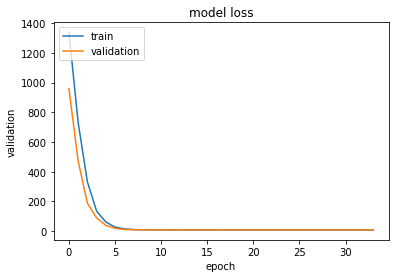

In [10]:

early_stopping_cb = EarlyStopping(
    monitor='loss', patience=15, verbose=1, min_delta=0.0001)

for config in grid:
    train_x, test_x = test_train_split()
    model = create_models_from_params(
        layers=config["layers"],
        latent_layer=config["latent"],
        output_fn=config["output"],
        optimizer_fn=config["optimizer"],
        loss_fn=config["loss"],
        verbose=0)
    print(f"Training {config['name']}")
    model.summary()
    history = model.fit(
        train_x,
        train_x,
        validation_data=(test_x, test_x),
        epochs=2000,
        batch_size=config["batch_size"],
        shuffle=True,
        verbose=0,
        callbacks=[early_stopping_cb],
        )
    print(f"...Loss => {history.history['loss'][-1]}")
    plot_loss(history)

Training 16 latent dims, batch: 1024
Epoch 248: early stopping
...Loss => 0.0380583181977272
Training 32 latent dims, batch: 1024
Epoch 295: early stopping
...Loss => 0.03196757659316063
Training 48 latent dims, batch: 1024
Epoch 265: early stopping
...Loss => 0.028479667380452156
Training 64 latent dims, batch: 1024
Epoch 296: early stopping
...Loss => 0.02823105826973915
Training 96 latent dims, batch: 1024
Epoch 340: early stopping
...Loss => 0.02411162666976452
Training 120 latent dims, batch: 1024
Epoch 306: early stopping
...Loss => 0.02279544807970524
Training 128 latent dims, batch: 1024
Epoch 308: early stopping
...Loss => 0.022418981418013573
Training 136 latent dims, batch: 1024
Epoch 338: early stopping
...Loss => 0.02143894135951996
Training 144 latent dims, batch: 1024
Epoch 313: early stopping
...Loss => 0.02065536566078663
Training 152 latent dims, batch: 1024
Epoch 314: early stopping
...Loss => 0.020457983016967773
Training 160 latent dims, batch: 1024
Epoch 333: earl

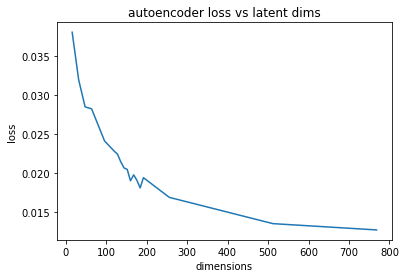

Best latent dims: 768, batch:1024 => 0.01269562728703022


In [34]:
# find best latent dims
early_stopping_cb = EarlyStopping(
    monitor='loss', patience=10, verbose=1, min_delta=0.00001)

best_loss = {"dims": 0, "loss": 100}
test_dims = [16, 32, 48, 64, 96, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 256, 512, 768]
# test_dims = range(140, 180, 1)
# test_dims = [168]
test_batches = [1024]
test_history = []
for latent_dim in test_dims:
    for batch_size in test_batches:
        model = create_models_from_params(
            layers=[
                {"n": 768, "act": "relu"},
                # {"n": 512, "act": "relu"},
                # {"n": 256, "act": "relu"},
            ],
            latent_layer={"n": latent_dim, "act": "relu"},
            output_fn="tanh",
            optimizer_fn="adam",
            loss_fn="mse",
            verbose=0)
        print(f"Training {latent_dim} latent dims, batch: {batch_size}")
        history = model.fit(
            train_x,
            train_x,
            validation_data=(test_x, test_x),
            epochs=2000,
            batch_size=1024,
            validation_split=0.1,
            shuffle=True,
            verbose=0,
            callbacks=[early_stopping_cb],
        )
        loss = history.history['val_loss'][-1]
        print(f"...Loss => {loss}")
        test_history.append(loss)
        if loss < best_loss["loss"]:
            best_loss = {
                "dims": latent_dim, "loss": loss, "batch_size": batch_size}

# results
plt.plot(test_dims, test_history)
plt.title('autoencoder loss vs latent dims')
plt.ylabel('loss')
plt.xlabel('dimensions')
plt.show()
print(
    f"Best latent dims: {best_loss['dims']}, "
    f"batch:{best_loss['batch_size']} => {best_loss['loss']}")